# Hệ thống huấn luyện mô hình nhận dạng dấu thanh

Hệ thống sử dụng MediaPipe để nhận dạng 5 dấu thanh: huyền, sắc, hỏi, ngã, nặng thông qua các hành động tay.

## Các bước thực hiện:
1. Import thư viện và khởi tạo
2. Kiểm tra dữ liệu
3. Chuẩn bị dữ liệu
4. Xây dựng mô hình LSTM
5. Xây dựng mô hình CNN
6. Huấn luyện mô hình
7. Đánh giá kết quả

## 1. Import thư viện và khởi tạo

In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from utils.data_utils import DataProcessor

# Thiết lập matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)

TensorFlow version: 2.19.0
NumPy version: 1.26.3


## 2. Khởi tạo DataProcessor và kiểm tra dữ liệu

In [12]:
# Khởi tạo DataProcessor
data_processor = DataProcessor()
classes = data_processor.classes
class_names = data_processor.class_names

print("=== THÔNG TIN DỮ LIỆU ===")
print(f"Số lớp: {len(classes)}")
print("Các lớp:", [class_names[cls] for cls in classes])

# Kiểm tra thống kê dữ liệu
stats = data_processor.get_data_statistics()
print(f"\nThống kê dữ liệu:")
for cls in classes:
    print(f"  {class_names[cls]}: {stats[cls]} mẫu")
print(f"Tổng cộng: {stats['total']} mẫu")

if stats['total'] < 50:
    print("\n⚠️  CẢNH BÁO: Dữ liệu quá ít! Cần thu thập thêm dữ liệu.")
else:
    print("\n✅ Dữ liệu đủ để huấn luyện!")

=== THÔNG TIN DỮ LIỆU ===
Số lớp: 5
Các lớp: ['Huyền', 'Sắc', 'Hỏi', 'Ngã', 'Nặng']

Thống kê dữ liệu:
  Huyền: 30 mẫu
  Sắc: 30 mẫu
  Hỏi: 30 mẫu
  Ngã: 30 mẫu
  Nặng: 30 mẫu
Tổng cộng: 150 mẫu

✅ Dữ liệu đủ để huấn luyện!


## 3. Chuẩn bị dữ liệu cho huấn luyện

In [13]:
print("Đang chuẩn bị dữ liệu...")

# Tải dữ liệu
X_train, X_test, y_train, y_test, label_encoder = data_processor.prepare_training_data(
    test_size=0.2
)

# Chia validation từ training
val_size = int(0.2 * len(X_train))
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]
X_train = X_train[:-val_size]
y_train = y_train[:-val_size]

# Cập nhật input shape
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(classes)

print(f"\nShape dữ liệu:")
print(f"  Training: {X_train.shape}")
print(f"  Validation: {X_val.shape}")
print(f"  Test: {X_test.shape}")
print(f"  Input shape: {input_shape}")
print(f"  Số lớp: {num_classes}")

# Hiển thị phân bố dữ liệu
print(f"\nPhân bố dữ liệu training:")
unique, counts = np.unique(y_train, return_counts=True)
for i, (cls_idx, count) in enumerate(zip(unique, counts)):
    cls_name = label_encoder.inverse_transform([cls_idx])[0]
    print(f"  {class_names[cls_name]}: {count} mẫu")

Đang chuẩn bị dữ liệu...

Shape dữ liệu:
  Training: (96, 30, 63)
  Validation: (24, 30, 63)
  Test: (30, 30, 63)
  Input shape: (30, 63)
  Số lớp: 5

Phân bố dữ liệu training:
  Hỏi: 20 mẫu
  Huyền: 19 mẫu
  Nặng: 19 mẫu
  Ngã: 19 mẫu
  Sắc: 19 mẫu


## 4. Xây dựng mô hình LSTM

In [14]:
def build_lstm_model(input_shape, num_classes):
    """Xây dựng mô hình LSTM"""
    model = models.Sequential([
        # LSTM layers
        layers.LSTM(128, return_sequences=True, input_shape=input_shape),
        layers.Dropout(0.3),
        layers.LSTM(64, return_sequences=False),
        layers.Dropout(0.3),
        
        # Dense layers
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Tạo mô hình LSTM
lstm_model = build_lstm_model(input_shape, num_classes)
print("=== MÔ HÌNH LSTM ===")
lstm_model.summary()

=== MÔ HÌNH LSTM ===


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 128)        │        98,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,117 (602.02 KB)

 Trainable params: 154,117 (602.02 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Xây dựng mô hình CNN

In [15]:
def build_1d_cnn_model(input_shape, num_classes):
    """Xây dựng mô hình 1D-CNN"""
    model = models.Sequential([
        # 1D Convolutional layers
        layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        
        layers.Conv1D(128, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),
        
        layers.Conv1D(256, kernel_size=3, activation='relu'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        layers.Dropout(0.3),
        
        # Dense layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Tạo mô hình CNN
cnn_model = build_1d_cnn_model(input_shape, num_classes)
print("=== MÔ HÌNH CNN ===")
cnn_model.summary()

=== MÔ HÌNH CNN ===


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 28, 64)         │        12,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 4, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,693 (698.02 KB)

 Trainable params: 177,797 (694.52 KB)

 Non-trainable params: 896 (3.50 KB)

## 6. Huấn luyện mô hình LSTM

In [16]:
# Thiết lập callbacks cho LSTM
lstm_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7
    ),
    callbacks.ModelCheckpoint(
        filepath='trained_models/lstm_model_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Huấn luyện mô hình LSTM
print("=== HUẤN LUYỆN MÔ HÌNH LSTM ===")
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=lstm_callbacks,
    verbose=1
)

=== HUẤN LUYỆN MÔ HÌNH LSTM ===
Epoch 1/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.0938 - loss: 1.6303
Epoch 1: val_accuracy improved from -inf to 0.41667, saving model to trained_models/lstm_model_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 239ms/step - accuracy: 0.1576 - loss: 1.6197 - val_accuracy: 0.4167 - val_loss: 1.5987 - learning_rate: 0.0010
Epoch 2/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1875 - loss: 1.6200
Epoch 2: val_accuracy did not improve from 0.41667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.1966 - loss: 1.6117 - val_accuracy: 0.2083 - val_loss: 1.5949 - learning_rate: 0.0010
Epoch 3/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1562 - loss: 1.5999
Epoch 3: val_accuracy did not improve from 0.41667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1979 - loss: 1.6005 - val_accuracy: 0.3333 - val_loss: 1.5889 - learning_rate: 0.0010
Epoch 4/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2500 - loss: 1.5748
Epoch 4: val_accuracy did not improve from 0.41667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2357 - loss: 1.5839 - val_accuracy: 0.3750 - val_loss: 1.5766 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2747 - loss: 1.5281 - val_accuracy: 0.5000 - val_loss: 1.4531 - learning_rate: 0.0010
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3958 - loss: 1.4602
Epoch 9: val_accuracy improved from 0.50000 to 0.79167, saving model to trained_models/lstm_model_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.3828 - loss: 1.4605 - val_accuracy: 0.7917 - val_loss: 1.3802 - learning_rate: 0.0010
Epoch 10/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5000 - loss: 1.3752
Epoch 10: val_accuracy did not improve from 0.79167
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4414 - loss: 1.3545 - val_accuracy: 0.3750 - val_loss: 1.4356 - learning_rate: 0.0010
Epoch 11/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5625 - loss: 1.3683
Epoch 11: val_accuracy did not improve from 0.79167
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4688 - loss: 1.3678 - val_accuracy: 0.5000 - val_loss: 1.3037 - learning_rate: 0.0010
Epoch 12/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6250 - loss: 1.2561
Epoch 12: val_accuracy did not improve from 0.79167
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5833 - loss: 1.2556 - val_accuracy: 0.3750 - val_loss: 1.1306 - learning_rate: 0.0010
Epoch 13/100
1/3 ━━━━━━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6940 - loss: 0.7101 - val_accuracy: 0.9583 - val_loss: 0.4805 - learning_rate: 0.0010
Epoch 19/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7188 - loss: 0.7657
Epoch 19: val_accuracy did not improve from 0.95833
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7370 - loss: 0.7580 - val_accuracy: 0.8750 - val_loss: 0.4374 - learning_rate: 0.0010
Epoch 20/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8750 - loss: 0.4229
Epoch 20: val_accuracy did not improve from 0.95833
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8346 - loss: 0.4748 - val_accuracy: 0.8750 - val_loss: 0.6295 - learning_rate: 0.0010
Epoch 21/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7500 - loss: 0.6164
Epoch 21: val_accuracy did not improve from 0.95833
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7826 - loss: 0.5814 - val_accuracy: 0.7917 - val_loss: 0.3488 - learning_rate: 0.0010
Epoch 22/100
3/3 ━━━━━━━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9076 - loss: 0.2960 - val_accuracy: 1.0000 - val_loss: 0.0731 - learning_rate: 0.0010
Epoch 29/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 1.0000 - loss: 0.1316
Epoch 29: val_accuracy did not improve from 1.00000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.9766 - loss: 0.1592 - val_accuracy: 0.9583 - val_loss: 0.0814 - learning_rate: 0.0010
Epoch 30/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9688 - loss: 0.1470
Epoch 30: val_accuracy did not improve from 1.00000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9375 - loss: 0.2098 - val_accuracy: 1.0000 - val_loss: 0.0547 - learning_rate: 0.0010
Epoch 31/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9688 - loss: 0.1651
Epoch 31: val_accuracy did not improve from 1.00000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8763 - loss: 0.3884 - val_accuracy: 0.8333 - val_loss: 0.5933 - learning_rate: 0.0010
Epoch 32/100
1/3 ━━━━━━━━━━━━━━━━━━━━

## 7. Huấn luyện mô hình CNN

In [17]:
# Thiết lập callbacks cho CNN
cnn_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7
    ),
    callbacks.ModelCheckpoint(
        filepath='trained_models/cnn_model_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Huấn luyện mô hình CNN
print("=== HUẤN LUYỆN MÔ HÌNH CNN ===")
cnn_history = cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=cnn_callbacks,
    verbose=1
)

=== HUẤN LUYỆN MÔ HÌNH CNN ===
Epoch 1/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.0938 - loss: 1.9881
Epoch 1: val_accuracy improved from -inf to 0.20833, saving model to trained_models/cnn_model_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 217ms/step - accuracy: 0.2552 - loss: 1.6858 - val_accuracy: 0.2083 - val_loss: 1.5910 - learning_rate: 0.0010
Epoch 2/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7812 - loss: 0.8222
Epoch 2: val_accuracy did not improve from 0.20833
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8060 - loss: 0.7178 - val_accuracy: 0.2083 - val_loss: 1.5951 - learning_rate: 0.0010
Epoch 3/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9062 - loss: 0.5132
Epoch 3: val_accuracy did not improve from 0.20833
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9401 - loss: 0.4107 - val_accuracy: 0.2083 - val_loss: 1.5994 - learning_rate: 0.0010
Epoch 4/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9688 - loss: 0.2380
Epoch 4: val_accuracy did not improve from 0.20833
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.9635 - loss: 0.2059 - val_accuracy: 0.2083 - val_loss: 1.6003 - learning_rate: 0.0010
Epoch 5/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9909 - loss: 0.0125 - val_accuracy: 0.2500 - val_loss: 1.5058 - learning_rate: 0.0010
Epoch 17/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 17: val_accuracy improved from 0.25000 to 0.33333, saving model to trained_models/cnn_model_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.3333 - val_loss: 1.4884 - learning_rate: 0.0010
Epoch 18/100
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 1.0000 - loss: 0.0049
Epoch 18: val_accuracy improved from 0.33333 to 0.37500, saving model to trained_models/cnn_model_best.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.3750 - val_loss: 1.4849 - learning_rate: 0.0010
Epoch 19/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 19: val_accuracy did not improve from 0.37500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.3750 - val_loss: 1.4954 - learning_rate: 0.0010
Epoch 20/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 0.0040
Epoch 20: val_accuracy did not improve from 0.37500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 0.3750 - val_loss: 1.5185 - learning_rate: 0.0010
Epoch 21/100
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 21: val_accuracy did not improve from 0.37500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.3750 - val_loss: 1.5415 - learning_rate: 0.0010
Epoch 22/100
1/3 ━━━━━━━━━━━━━━━━━━━

## 8. Đánh giá mô hình LSTM

=== ĐÁNH GIÁ MÔ HÌNH LSTM ===
Test Accuracy: 0.9667
Test Loss: 0.1090
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step

Classification Report:
              precision    recall  f1-score   support

       Huyền       1.00      0.83      0.91         6
         Sắc       0.86      1.00      0.92         6
         Hỏi       1.00      1.00      1.00         6
         Ngã       1.00      1.00      1.00         6
        Nặng       1.00      1.00      1.00         6

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



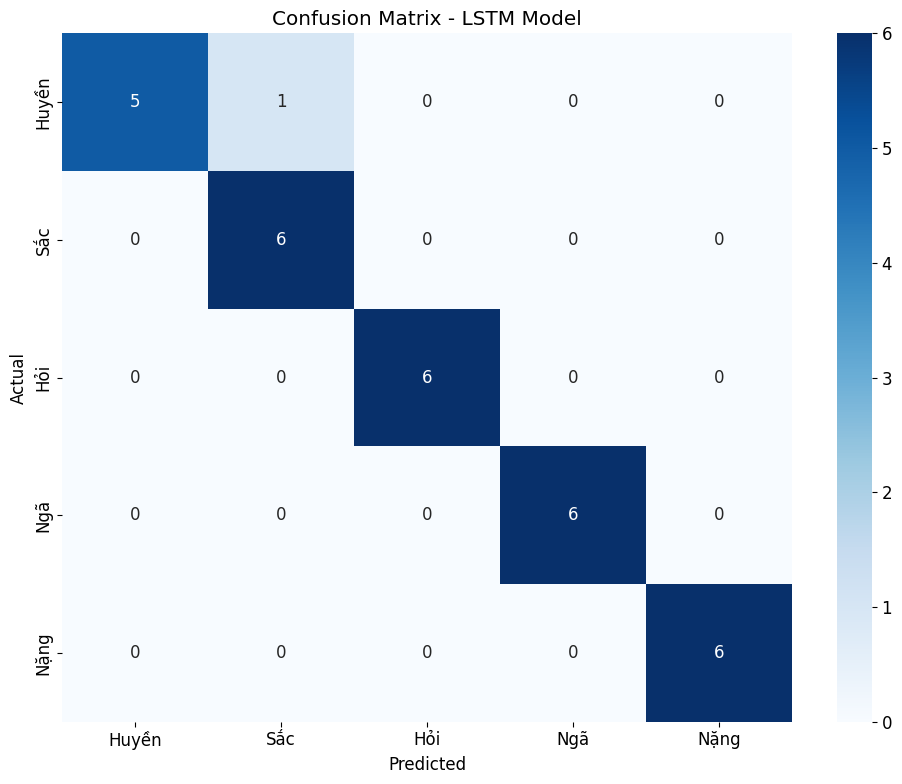

In [18]:
# Đánh giá mô hình LSTM
print("=== ĐÁNH GIÁ MÔ HÌNH LSTM ===")
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {lstm_test_accuracy:.4f}")
print(f"Test Loss: {lstm_test_loss:.4f}")

# Dự đoán
lstm_y_pred = lstm_model.predict(X_test)
lstm_y_pred_classes = np.argmax(lstm_y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, lstm_y_pred_classes, 
                          target_names=[class_names[cls] for cls in classes]))

# Confusion matrix
lstm_cm = confusion_matrix(y_test, lstm_y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=[class_names[cls] for cls in classes],
           yticklabels=[class_names[cls] for cls in classes])
plt.title('Confusion Matrix - LSTM Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## 9. Đánh giá mô hình CNN

=== ĐÁNH GIÁ MÔ HÌNH CNN ===
Test Accuracy: 0.4000
Test Loss: 1.4538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step

Classification Report:
              precision    recall  f1-score   support

       Huyền       0.38      1.00      0.55         6
         Sắc       0.00      0.00      0.00         6
         Hỏi       0.43      1.00      0.60         6
         Ngã       0.00      0.00      0.00         6
        Nặng       0.00      0.00      0.00         6

    accuracy                           0.40        30
   macro avg       0.16      0.40      0.23        30
weighted avg       0.16      0.40      0.23        30



c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

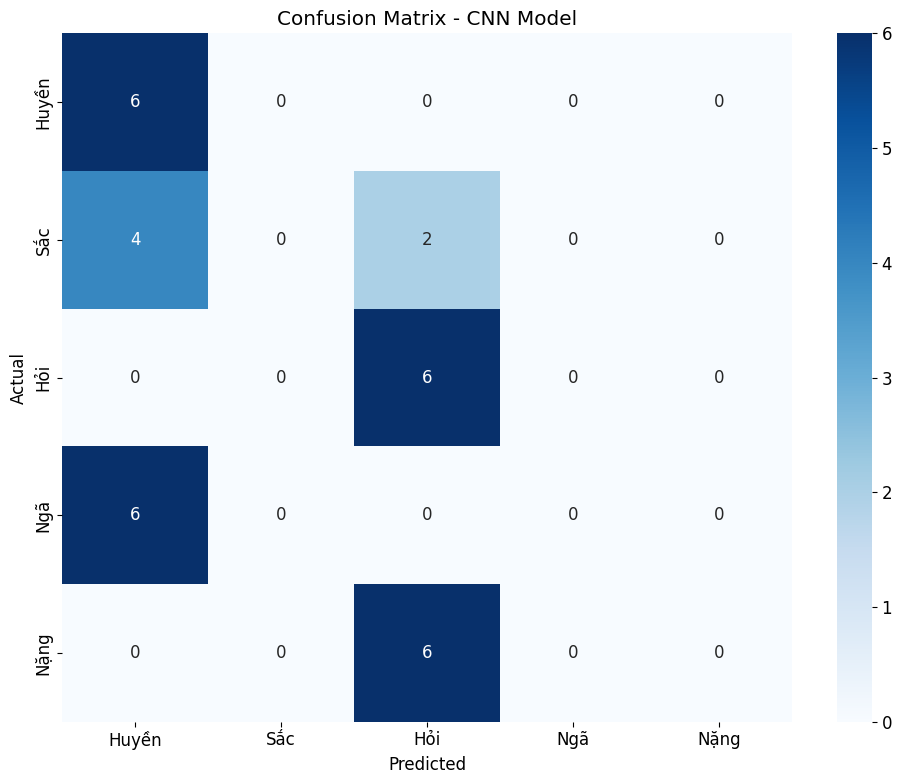

In [19]:
# Đánh giá mô hình CNN
print("=== ĐÁNH GIÁ MÔ HÌNH CNN ===")
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {cnn_test_accuracy:.4f}")
print(f"Test Loss: {cnn_test_loss:.4f}")

# Dự đoán
cnn_y_pred = cnn_model.predict(X_test)
cnn_y_pred_classes = np.argmax(cnn_y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, cnn_y_pred_classes, 
                          target_names=[class_names[cls] for cls in classes]))

# Confusion matrix
cnn_cm = confusion_matrix(y_test, cnn_y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=[class_names[cls] for cls in classes],
           yticklabels=[class_names[cls] for cls in classes])
plt.title('Confusion Matrix - CNN Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## 10. So sánh hiệu suất hai mô hình

=== SO SÁNH HIỆU SUẤT MÔ HÌNH ===
LSTM Accuracy: 0.9667
CNN Accuracy: 0.4000

🏆 LSTM hoạt động tốt hơn!


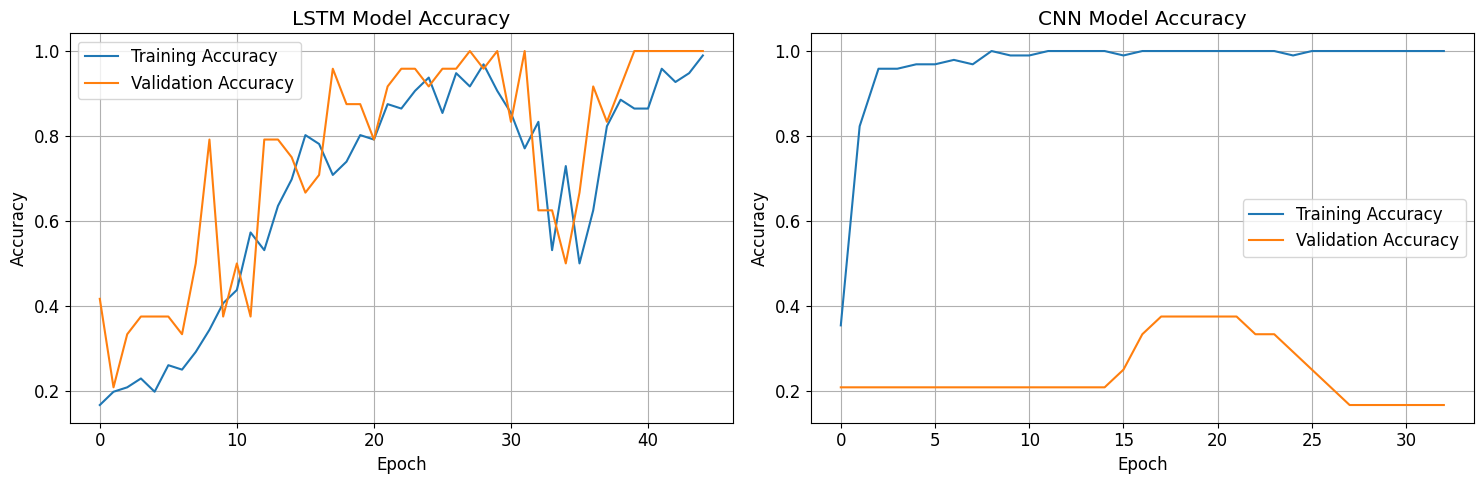

In [20]:
# So sánh hiệu suất
print("=== SO SÁNH HIỆU SUẤT MÔ HÌNH ===")
print(f"LSTM Accuracy: {lstm_test_accuracy:.4f}")
print(f"CNN Accuracy: {cnn_test_accuracy:.4f}")

if lstm_test_accuracy > cnn_test_accuracy:
    print("\n🏆 LSTM hoạt động tốt hơn!")
    best_model = lstm_model
    best_model_name = 'lstm'
elif cnn_test_accuracy > lstm_test_accuracy:
    print("\n🏆 CNN hoạt động tốt hơn!")
    best_model = cnn_model
    best_model_name = 'cnn'
else:
    print("\n🤝 Cả hai mô hình có hiệu suất tương đương!")
    best_model = lstm_model  # Mặc định chọn LSTM
    best_model_name = 'lstm'

# Vẽ biểu đồ so sánh accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# LSTM Training History
ax1.plot(lstm_history.history['accuracy'], label='Training Accuracy')
ax1.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('LSTM Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# CNN Training History
ax2.plot(cnn_history.history['accuracy'], label='Training Accuracy')
ax2.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('CNN Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 11. Lưu mô hình tốt nhất

In [21]:
# Tạo thư mục trained_models nếu chưa có
os.makedirs('trained_models', exist_ok=True)

# Lưu mô hình tốt nhất
best_model_path = f'trained_models/{best_model_name}_model_final.h5'
best_model.save(best_model_path)

# Lưu label encoder
encoder_path = f'trained_models/{best_model_name}_model_label_encoder.pkl'
data_processor.save_label_encoder(encoder_path)

print(f"\n✅ Mô hình tốt nhất đã được lưu:")
print(f"  - Mô hình: {best_model_path}")
print(f"  - Label encoder: {encoder_path}")
print(f"  - Loại mô hình: {best_model_name.upper()}")
print(f"  - Accuracy: {max(lstm_test_accuracy, cnn_test_accuracy):.4f}")


✅ Mô hình tốt nhất đã được lưu:
  - Mô hình: trained_models/lstm_model_final.h5
  - Label encoder: trained_models/lstm_model_label_encoder.pkl
  - Loại mô hình: LSTM
  - Accuracy: 0.9667


## 12. Tóm tắt kết quả

In [22]:
# Tóm tắt kết quả
print("=== TÓM TẮT KẾT QUẢ HUẤN LUYỆN ===")
print(f"\n📊 Thống kê dữ liệu:")
for cls in classes:
    print(f"  - {class_names[cls]}: {stats[cls]} mẫu")
print(f"  - Tổng cộng: {stats['total']} mẫu")

print(f"\n🤖 Kết quả mô hình:")
print(f"  - LSTM Accuracy: {lstm_test_accuracy:.4f}")
print(f"  - CNN Accuracy: {cnn_test_accuracy:.4f}")
print(f"  - Mô hình tốt nhất: {best_model_name.upper()}")

print(f"\n💾 Mô hình đã được lưu tại:")
print(f"  - {best_model_path}")
print(f"  - {encoder_path}")

print(f"\n🎯 Bước tiếp theo:")
print(f"  - Chạy predict.py để test mô hình")
print(f"  - Hoặc sử dụng mô hình trong ứng dụng thực tế")

=== TÓM TẮT KẾT QUẢ HUẤN LUYỆN ===

📊 Thống kê dữ liệu:
  - Huyền: 30 mẫu
  - Sắc: 30 mẫu
  - Hỏi: 30 mẫu
  - Ngã: 30 mẫu
  - Nặng: 30 mẫu
  - Tổng cộng: 150 mẫu

🤖 Kết quả mô hình:
  - LSTM Accuracy: 0.9667
  - CNN Accuracy: 0.4000
  - Mô hình tốt nhất: LSTM

💾 Mô hình đã được lưu tại:
  - trained_models/lstm_model_final.h5
  - trained_models/lstm_model_label_encoder.pkl

🎯 Bước tiếp theo:
  - Chạy predict.py để test mô hình
  - Hoặc sử dụng mô hình trong ứng dụng thực tế
